## 1st-level analysis

In this example, we will take the preprocessed output from the Fmriprep and run for each subject a 1st-level analysis. For this we need to do the following steps:

0. Smooth the normalized result as fmriprep doesn't do this step
1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts
5. Plot T- and beta-images


**So, let's begin!**

## Imports

First, we need to import all the modules we later want to use.

In [2]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Smooth, Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import MapNode
from nipype import Workflow, Node
# MATLAB - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/imaging/mz01/osl2.0.3.2/spm12')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [3]:
experiment_dir = '/imaging/mz01/fmriprep'
output_dir = '/imaging/mz01/fmriprep/output_1stlevel'
working_dir = '/imaging/mz01/fmriprep/workingdir_1stlevel'

# list of subject identifiers
subject_list = ['01','02','04','05','03','06','07','08','09','10',\
            '11','12','13','14','15','16','18','17','26','20','19',\
            '21','22','23','24','25','27','28']
# subject_list = ['11']
# TR of functional images
with open('/imaging/mz01/fmriprep/output/sub-01/func/sub-01_task-stm-run-01_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing kernel to use
fwhm = [6]

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [4]:
# Apply spatial smoothing first since fmriprep doesn't do this step
smoothing = Node(Smooth(fwhm= fwhm*3),
                name="smoothing")

#unzip nii.gz files
gunzip_con = MapNode(Gunzip(), name="gunzip_con", iterfield=['in_file'])

# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had 2 different conditions **short-term memory and attentional control**. Each condition is modelled separately.

STM condition contains **load and error (deg)** as parametric modulator

AC condition contains **difficulty level and target present/not present trials**. Former is parametric.




In [10]:
# Condition names
# Nipype has this idiotic thing where if you specify parametric modulators
# the interaction term created is of format  "main_regressor_namexpmod_name^1"
condition_names = [' memory',' memoryxload^1']

# Contrasts
cont01 = ['memory_maineffect', 'T', condition_names, [1,0]]  
cont02 = ['load',    'T', condition_names, [0, 1]]
cont03 = ['error',  'T', condition_names, [0, 0]]


contrast_list = [cont01,cont02]

helper function ``subjectinfo``: grab run information from tsv file to create regressors

In [11]:
def subjectinfo(subject_id):
    import glob
    import pandas as pd
    from nipype.interfaces.base import Bunch
    #Grab event files
    pattern = '/imaging/mz01/fmriprep/output/sub-%s/func/sub-%s_run*stm*.tsv' % (subject_id, subject_id)
    path = sorted(glob.glob(pattern))
    ##print(path)
    assert len(path)>0, f"could not find subject for {pattern}"

    #Grab confound files
    pattern_confound = '/imaging/mz01/fmriprep/fmriprep/sub-%s/func/sub-%s*stm*.tsv' % (subject_id, subject_id)
    path_confound = sorted(glob.glob(pattern_confound))
    ##print (path_confound)
    subject_info=[]
    for i in range(len(path)):
        trialinfo = pd.read_table(path[i])
        conditions = [trialinfo.condition.values[0]]
        onsets = []
        durations = []
        load = []
        #error= []
        for j in range(trialinfo.shape[0]):
            onsets.append(round(trialinfo.fixation_onset.values[j],0)) 
            durations.append(round(trialinfo.duration.values[j],0))
            load.append(trialinfo.load.values[j])
            #error.append(trialinfo.error.values[j])
        #confound parameters
        confounds =pd.read_csv(path_confound[i], sep="\t", na_values="n/a")
    
        subject_info.append(Bunch(conditions=conditions,
                              onsets=[onsets],
                              durations=[durations],
                              pmod=[Bunch(name=['load'],poly=[1],
                                         param=[load]), None],
                              #Include motion regressors
                              regressors = [#list(confounds.FramewiseDisplacement.fillna(0)),
                                             list(confounds.X),
                                            list(confounds.Y),
                                            list(confounds.Z),
                                            list(confounds.RotX),
                                            list(confounds.RotY),
                                            list(confounds.RotZ)
                              ],
                              regresssor_names=[#'FramewiseDisplacement',
                                                'X',
                                                'Y',
                                                'Z',
                                                'RotX',
                                                'RotY',
                                                'RotZ'],
                                orth=['No'] #idk if this argument works
                              #amplitudes=None,
                              #tmod=None,
                             ))

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [12]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)
                        ]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': 'fmriprep/sub-'+'{subject_id}/func/*stm*_preproc.nii.gz'}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'memory'


# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]

datasink.inputs.substitutions = substitutions



## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [13]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (selectfiles, gunzip_con, [('func', 'in_file')]),
                    (gunzip_con, smoothing, [('out_file',
                                             'in_files')]),
                    (smoothing, modelspec, [('smoothed_files',
                                            'functional_runs')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])



## Visualize the workflow

It always helps to visualize your workflow.

190827-11:24:12,911 nipype.workflow INFO:
	 Generated workflow graph: /imaging/mz01/fmriprep/workingdir_1stlevel/l1analysis/graph.png (graph2use=colored, simple_form=True).


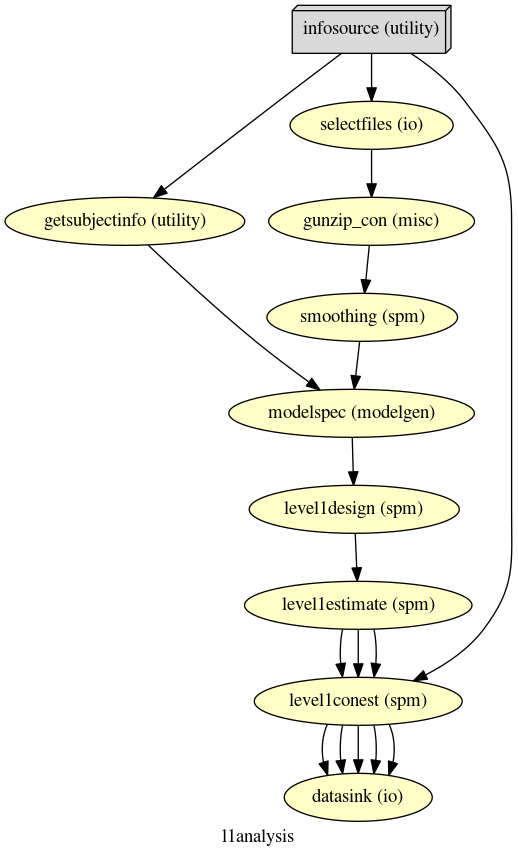

In [87]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [14]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 8})

190830-11:18:54,480 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
190830-11:18:54,781 nipype.workflow INFO:
	 Running in parallel.
190830-11:18:54,794 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 56 jobs ready. Free memory (GB): 226.62/226.62, Free processors: 8/8.
190830-11:18:54,932 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
190830-11:18:54,933 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/imaging/mz01/fmriprep/workingdir_1stlevel/l1analysis/_subject_id_28/selectfiles".
190830-11:18:54,940 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
190830-11:18:54,938 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/imaging/mz01/fmriprep/workingdir_1stlevel/l1analysis/_subject_id_28/getsubjectinfo".
190830-11:18:54,941 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/imaging/mz

/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: 

190830-11:18:56,796 nipype.workflow INFO:
	 [Job 0] Completed (l1analysis.selectfiles).
190830-11:18:56,800 nipype.workflow INFO:
	 [Job 9] Completed (l1analysis.selectfiles).
190830-11:18:56,803 nipype.workflow INFO:
	 [Job 18] Completed (l1analysis.selectfiles).
190830-11:18:56,807 nipype.workflow INFO:
	 [Job 27] Completed (l1analysis.selectfiles).
190830-11:18:56,813 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 52 jobs ready. Free memory (GB): 225.82/226.62, Free processors: 4/8.
                     Currently running:
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
190830-11:18:56,973 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
190830-11:18:56,973 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/imaging/mz01/fmriprep/workingdir_1stlevel/l1analysis/_subj

/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


190830-11:18:58,797 nipype.workflow INFO:
	 [Job 36] Completed (l1analysis.selectfiles).
190830-11:18:58,801 nipype.workflow INFO:
	 [Job 45] Completed (l1analysis.selectfiles).
190830-11:18:58,808 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 59 jobs ready. Free memory (GB): 225.42/226.62, Free processors: 2/8.
                     Currently running:
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
190830-11:18:58,926 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.getsubjectinfo".
190830-11:18:58,926 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/imaging/mz01/fmriprep/workingdir_1stlevel/l1analysis/_subject_id_21/selectfiles".
190830-11:18:58,929 nipype.workflow INFO:
	 [Node]

/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


190830-11:19:00,798 nipype.workflow INFO:
	 [Job 54] Completed (l1analysis.selectfiles).
190830-11:19:00,805 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 62 jobs ready. Free memory (GB): 225.22/226.62, Free processors: 1/8.
                     Currently running:
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
                       * l1analysis.getsubjectinfo
190830-11:19:00,916 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/imaging/mz01/fmriprep/workingdir_1stlevel/l1analysis/_subject_id_19/selectfiles".
190830-11:19:00,934 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
190830-11:19:00,948 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles

/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)



190830-11:19:02,988 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".


/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


190830-11:19:02,997 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
190830-11:19:03,217 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
190830-11:19:03,221 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
190830-11:19:03,261 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
190830-11:19:03,525 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
190830-11:19:04,802 nipype.workflow INFO:
	 [Job 66] Completed (l1analysis.getsubjectinfo).
190830-11:19:04,805 nipype.workflow INFO:
	 [Job 72] Completed (l1analysis.selectfiles).
190830-11:19:04,809 nipype.workflow INFO:
	 [Job 75] Completed (l1analysis.getsubjectinfo).
190830-11:19:04,812 nipype.workflow INFO:
	 [Job 81] Completed (l1analysis.selectfiles).
190830-11:19:04,815 nipype.workflow INFO:
	 [Job 84] Completed (l1analysis.getsubjectinfo).
190830-11:19:04,818 nipype.workflow INFO:
	 [Job 90] Completed (l1analysis.selectfiles).
190830-11:19:04

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [92]:
!tree output_1stlevel/1stLevel/

output_1stlevel/1stLevel/ [error opening dir]

0 directories, 0 files


## Visualize results

Let's look at the contrasts of one subject that we've just computed. First, let's see what the difference of smoothing is for the contrast **`average`**

In [90]:
from nilearn import plotting
sub = '11'
anatimg = 'fmriprep/sub-%s/anat/sub-%s_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz' % (sub,sub)

In [91]:
plotting.plot_stat_map(
    'output_1stlevel/1stLevel/sub-%s/spmT_0001.nii'%(sub), title='average_sub%s'%sub,
    bg_img=anatimg, threshold=3, display_mode='ortho');

ValueError: File not found: 'fmriprep/sub-11/anat/sub-11_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz'

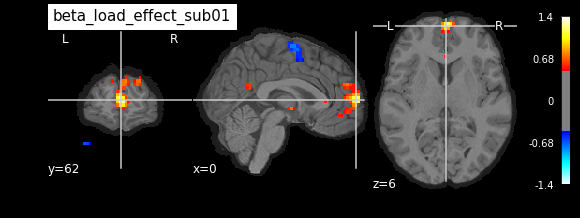

In [40]:
plotting.plot_stat_map(
    'output_1stlevel/1stLevel/sub-%s/con_0002.nii'%(sub), title='beta_load_effect_sub%s'%sub,
    bg_img=anatimg,  threshold=0.5, display_mode='ortho');

Interactive image

In [93]:
view = plotting.view_img('output_1stlevel/1stLevel/sub-%s/spmT_0002.nii'%(sub), bg_img = anatimg,
                         title='Tmap_load_effect_sub%s'%sub, threshold=5)
view

ValueError: File not found: 'output_1stlevel/1stLevel/sub-11/spmT_0002.nii'

In [46]:
view = plotting.view_img('output_1stlevel/1stLevel/sub-%s/spmT_0003.nii'%(sub), bg_img = anatimg,
                         title='Tmap_error_effect_sub%s'%sub, threshold=3)
view


/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


# Visualize design matrix


In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

First, let's look at the 1st-level Design Matrix of subject 01, to verify that everything is as it should be.


In [132]:
from scipy.io import loadmat

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('output_1stlevel/1stLevel/sub-%s/SPM.mat'%sub,
                 struct_as_record=False)
#access the matrix and name of regressors
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

#Now before we can plot it, we just need to normalize the desing matrix in such a way, 
#that each column has a maximum amplitude of 1. This is just for visualization purposes, 
#otherwise the rotation parameters with their rather small values will not show up in the figure.
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

FileNotFoundError: [Errno 2] No such file or directory: 'output_1stlevel/1stLevel/sub-11/SPM.mat'